# Kickstarter Project Final

## Introduction

Kickstarter provides a platform where artists, builders, and other creatives can turn to online audiences for support to materialize their ideas. But not every project on Kickstarter meets its funding goal. This notebook prepares, explores, and uses machine learning to discover if the success of Kickstarter projects can be predicted and optimized for success.

**The problem:**
 
Since Kickstarter launched in 2009, 473,134 teams and individuals have sought funding for their creative projects. 176,314 of these projects have been successful in meeting their funding goals, a success rate of only 37.49%. When a project does not meet its funding goal, the backers are not charged for the money they pledged. In other words, there is no such thing as partial funding on Kickstarter – a project that fails gets nothing. It’s a lose-lose situation: the creator loses an opportunity to make and sell their product, and the backers lose a chance to partake in their investment.  

Yet teams seeking funding devote time and effort into promoting and advertising to potential backers to raise the funds they need. How can a team maximize their chances of meeting funding goals? Can we predict what factors lead projects to success or failure, or is this merely a matter of luck?

**Who benefits?**

Crowdfunding platforms such as Kickstarter, GoFundMe, IndieGoGo, Causes, Patreon, and LendingClub may benefit from a prediction model to offer advice to funding-seekers using their platforms. This advice can include insights into what kinds of projects to choose, realistic funding goals, and appropriate timelines for fundraising. This is also directly useful to the users of these platforms since it can serve as guidelines to give their projects the best chance at success. Moreover, these insights can be translated into parallel advice for start-ups in the investment phases of their growth, as well as charity and non profit fundraising campaigns.

**About the data:**

This dataset has information for 378,661 Kickstarter projects launched between 2009 and 2018, including their titles, descriptions, project categories, geographical location, launch dates and deadlines, target funding goal, final total funding, outcomes, and number of contributors. This information can allow us to look for investment patterns across time, region, and project category, as well as the success or failure of various kinds of projects, defined as whether or not the funding goal was met. The dataset is available through [Kaggle](https://www.kaggle.com/ukveteran/kickstarter).

## Imports

Importing the relevant libraries for data wrangling, visualization, and machine learning.

In [1]:
#imports

#data wrangling and visualization
import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#statistical analysis
import scipy.stats
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import t
from scipy.stats import boxcox
import statsmodels.api as sm

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier

#style elements, hide warnings
import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')
%matplotlib inline

print('Done!')

Done!


# Data Cleaning

Cleaning steps:

- After reading in the CSV file, I ensured that the date columns are in datetime format, then created a "duration" column by subtracting the launch date from the deadline date. 


- Next I examined the data for anomalies and found that there were samples with 1970 and the year and N,0" as the country. Kickstarter did not exist in 1970, and it was impossible to determine what country N,0" was meant to be, so I deleted these rows. Seven rows contained 1970 as the year, and 3797 rows contained N,0" as the country, so from 378661 rows total, this removes 1.005% of the data.


- Next I removed all rows with "undefined" and "live" projects, since these could not be classified as either success or failure. There were 3562 undefined projects, and 2799 live projects, so from 378661 rows total, this removes 1.680% of the data. 


- I changed rows with canceled and suspended projects to "failed." Then I created a "rate" column and mapped the values from the status column there as "successful"=1 and "failed"=0.


- I saved the cleaned data to a new CSV.

In [2]:
#read the csv
df = pd.read_csv('kickstarter-projects.csv')

#Ensure that the "launched" and "deadline" columns are in datetime format
df["launched"] = df["launched"].astype("datetime64")
df["deadline"] = df["deadline"].astype("datetime64")
#create a column with project durations
df['duration'] = (df['deadline'] - df['launched']).dt.days

#get rid of rows that are mislabeled
# N,0" is not a country, Kickstarter did not exist in 1970
df1 = df[df['launched'].dt.year != 1970]
df2 = df1[df1['country'] != 'N,0"']

#Remove rows with undefined and live projects, since these are neither success nor failure
df_clean = df2[(df2.state != 'undefined') & (df2.state != 'live')]
#change canceled and suspended statuses to failed
df_clean.replace(to_replace=['canceled', 'suspended'], value='failed', inplace=True)

#Map successful and unsuccessful projects to a rate column containing 0 and 1 classifier labels
equiv = {'successful':1, 'failed':0}
df_clean['rate'] = df_clean['state'].map(equiv)

#save cleaned data  to csv for later use in machine learning steps
df_clean.to_csv('kickstarterClean.csv')

#preview data
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372059 entries, 0 to 378660
Data columns (total 17 columns):
ID                  372059 non-null int64
name                372055 non-null object
category            372059 non-null object
main_category       372059 non-null object
currency            372059 non-null object
deadline            372059 non-null datetime64[ns]
goal                372059 non-null float64
launched            372059 non-null datetime64[ns]
pledged             372059 non-null float64
state               372059 non-null object
backers             372059 non-null int64
country             372059 non-null object
usd pledged         372059 non-null float64
usd_pledged_real    372059 non-null float64
usd_goal_real       372059 non-null float64
duration            372059 non-null int64
rate                372059 non-null int64
dtypes: datetime64[ns](2), float64(5), int64(4), object(6)
memory usage: 51.1+ MB


In [3]:
#statistical information for the numeric columns
df_clean.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,duration,rate
count,3.720590e+05,3.720590e+05,3.720590e+05,372059.000000,3.720590e+05,3.720590e+05,3.720590e+05,372059.000000,372059.000000
mean,1.074583e+09,4.931894e+04,9.755597e+03,106.979291,7.080348e+03,9.145412e+03,4.573846e+04,33.175139,0.359757
std,6.191870e+08,1.182579e+06,9.626605e+04,914.527812,7.893179e+04,9.162182e+04,1.151693e+06,12.793462,0.479930
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000,0.000000
25%,5.378143e+08,2.000000e+03,3.100000e+01,2.000000,1.800000e+01,3.125000e+01,2.000000e+03,29.000000,0.000000
50%,1.075300e+09,5.500000e+03,6.250000e+02,12.000000,4.000000e+02,6.277700e+02,5.500000e+03,29.000000,0.000000
75%,1.610138e+09,1.650000e+04,4.093000e+03,57.000000,3.057000e+03,4.066000e+03,1.600000e+04,36.000000,1.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,91.000000,1.000000


In [4]:
#preview of the dataframe
df_clean.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,rate
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,58,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,59,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,44,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,29,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,failed,14,US,1283.0,1283.0,19500.00,55,0


# Data Exploration

Dividing into numerical and categorical data, I explore the features and distributions of the data.

## Numerical Data

### Barplot

This plot show a comparison of means from different columns, both for successful and unsuccessful projects. As we can see here, projects that asked for less money as their goal amount got more backers and more money pledged to them. 

Text(0, 0.5, 'Average')

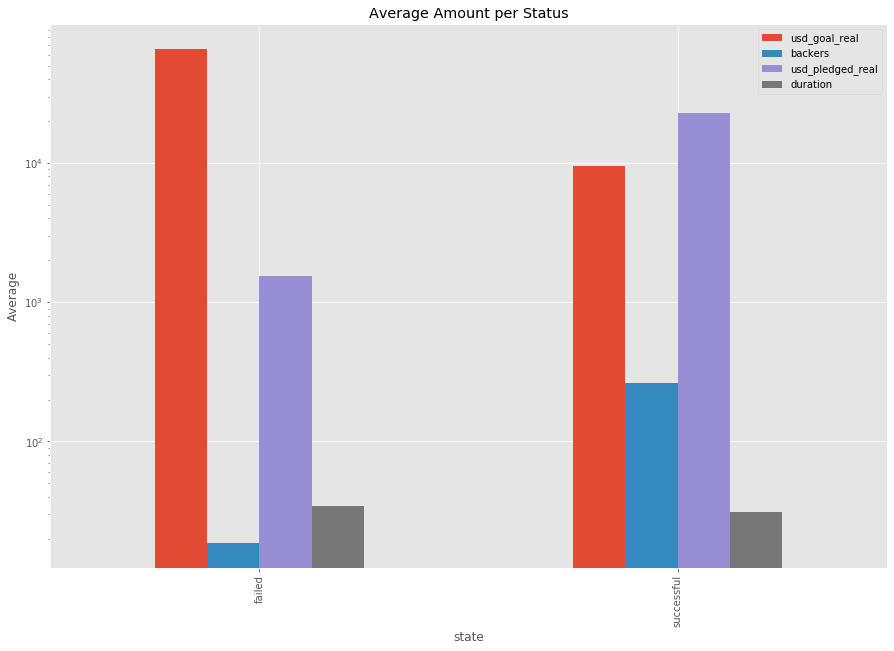

In [5]:
state = df_clean.groupby('state')[['usd_goal_real', 
                                   'backers', 
                                   'usd_pledged_real', 
                                   'duration']].mean().plot(kind='bar', figsize=(15,10),
                                                            title='Average Amount per Status').set_yscale('log')

plt.ylabel("Average")


### Scatter plots

These scatter plots show the relationship between the pledged amount of the project and the goal amount of the project.

[Text(0, 0.5, 'Goal Amount'), Text(0.5, 0, 'Pledged Amount')]

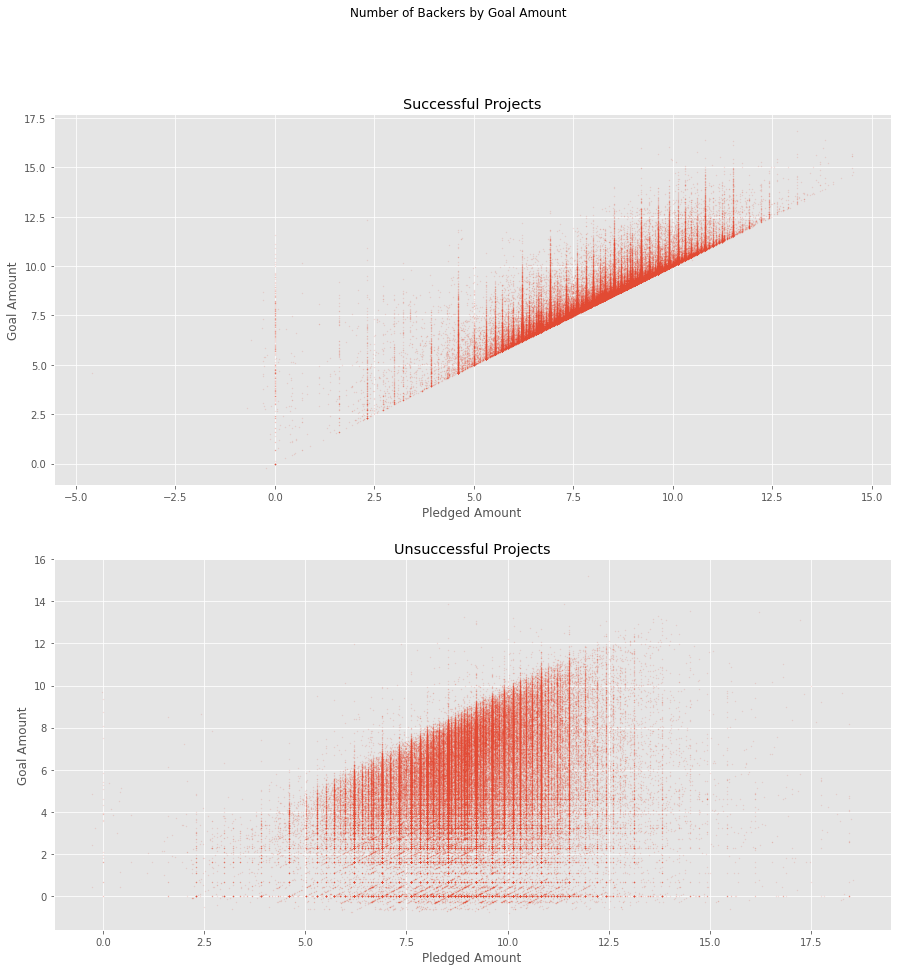

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
fig.suptitle('Number of Backers by Goal Amount')
ax1.scatter(np.log(df_clean['usd_goal_real'].loc[df_clean.rate == 1]), np.log(df_clean['usd_pledged_real'].loc[df_clean.rate == 1]), alpha=0.1, s=1)
ax1.set_title('Successful Projects')
ax1.set(xlabel='Pledged Amount', ylabel='Goal Amount')
ax2.scatter(np.log(df_clean['usd_goal_real'].loc[df_clean.rate == 0]), np.log(df_clean['usd_pledged_real'].loc[df_clean.rate == 0]), alpha=0.1, s=1)
ax2.set_title('Unsuccessful Projects')
ax2.set(xlabel='Pledged Amount', ylabel='Goal Amount')



## Categorical Data

### Barplots

These barplots show the distributions of key categorical values within the dataset. From this we can see that the data is unbalanced, with almost double the amount of failed projects as successes. We can also discern which project types are most popular, where most projects are located geographically, and how individuals plan projects by launch and deadline dates.

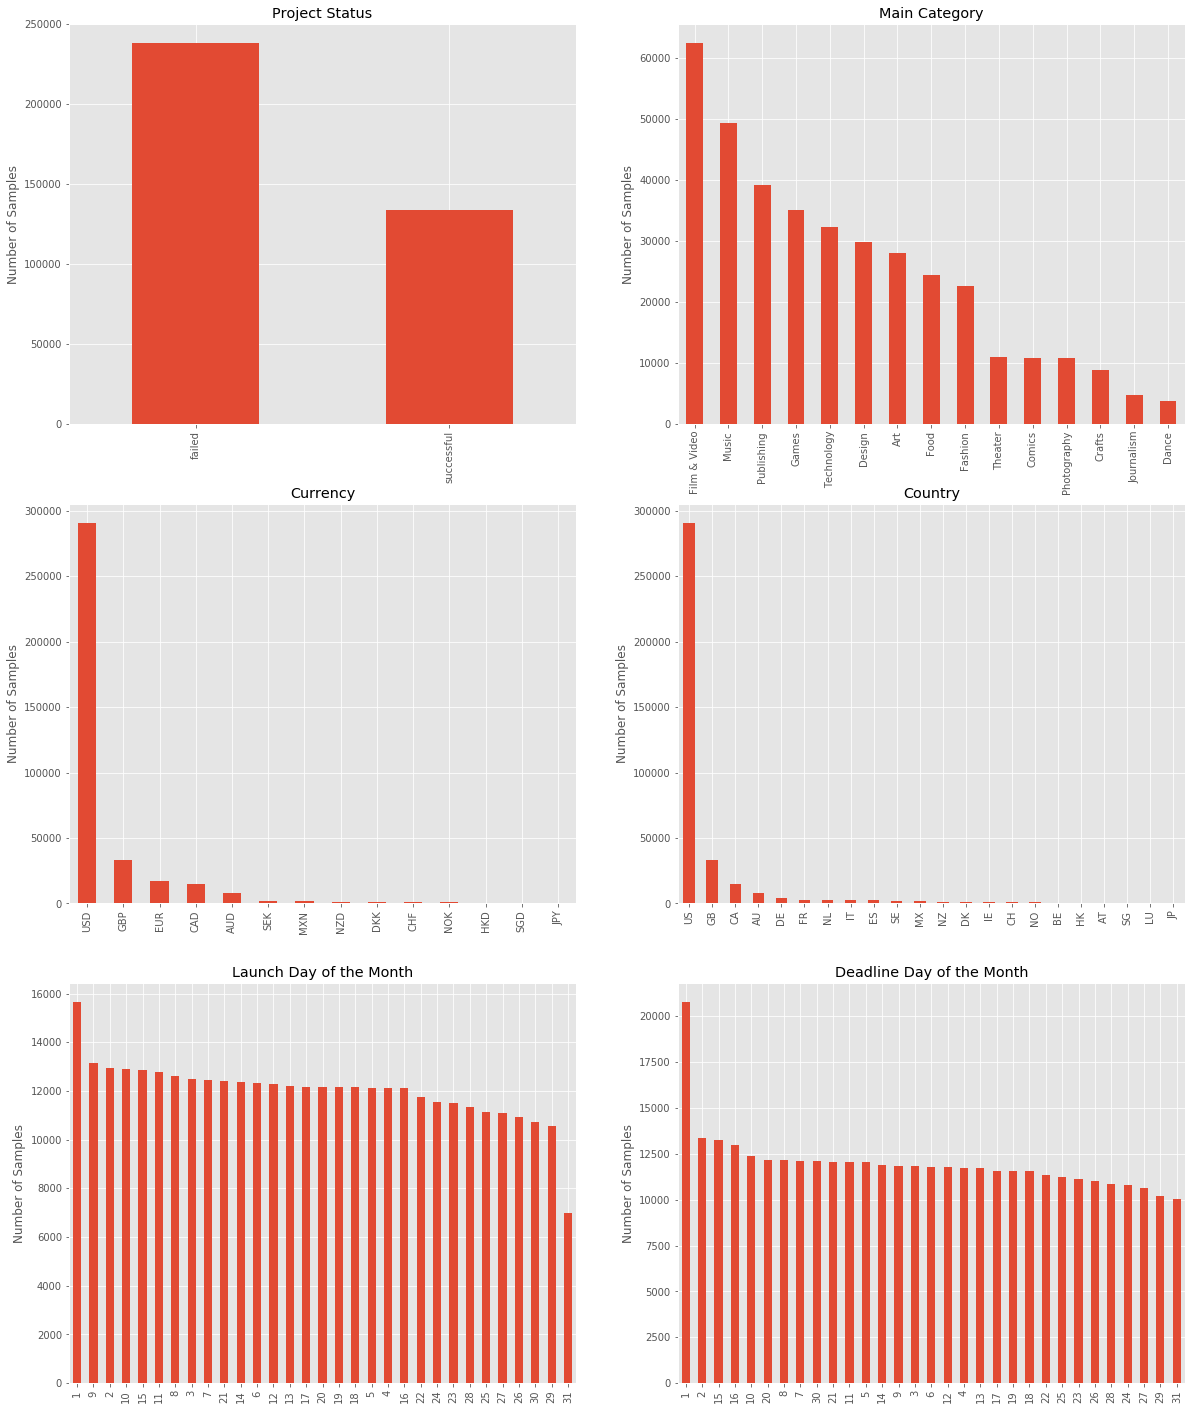

In [7]:
#Overview of the data

#Number of samples in certain categories


fig, ax =  plt.subplots(3,2, figsize=(20,25))
ax[0][0] = df_clean.state.value_counts().plot(ax=ax[0][0], kind='bar', title='Project Status')
ax[0][0].set_ylabel('Number of Samples')
ax[0][1] = df_clean.main_category.value_counts().plot(ax=ax[0][1], kind='bar', title='Main Category')
ax[0][1].set_ylabel('Number of Samples')
ax[1][0] = df_clean.currency.value_counts().plot(ax=ax[1][0], kind='bar', title='Currency')
ax[1][0].set_ylabel('Number of Samples')
ax[1][1] = df_clean.country.value_counts().plot(ax=ax[1][1], kind='bar', title='Country')
ax[1][1].set_ylabel('Number of Samples')
ax[2][0] = df_clean.launched.dt.day.value_counts().plot(ax=ax[2][0], kind='bar', title='Launch Day of the Month')
ax[2][0].set_ylabel('Number of Samples')
ax[2][1] = df_clean.deadline.dt.day.value_counts().plot(ax=ax[2][1], kind='bar', title='Deadline Day of the Month')
ax[2][1].set_ylabel('Number of Samples')
plt.show()




### Timeseries plots

Looking at the timeseries plots, we can see some trends in Kickstarter projects from 2009-2018. Projects have tended to be shorter in more recent years, goal amounts have generally decreased, and the amount pledged has increased. 

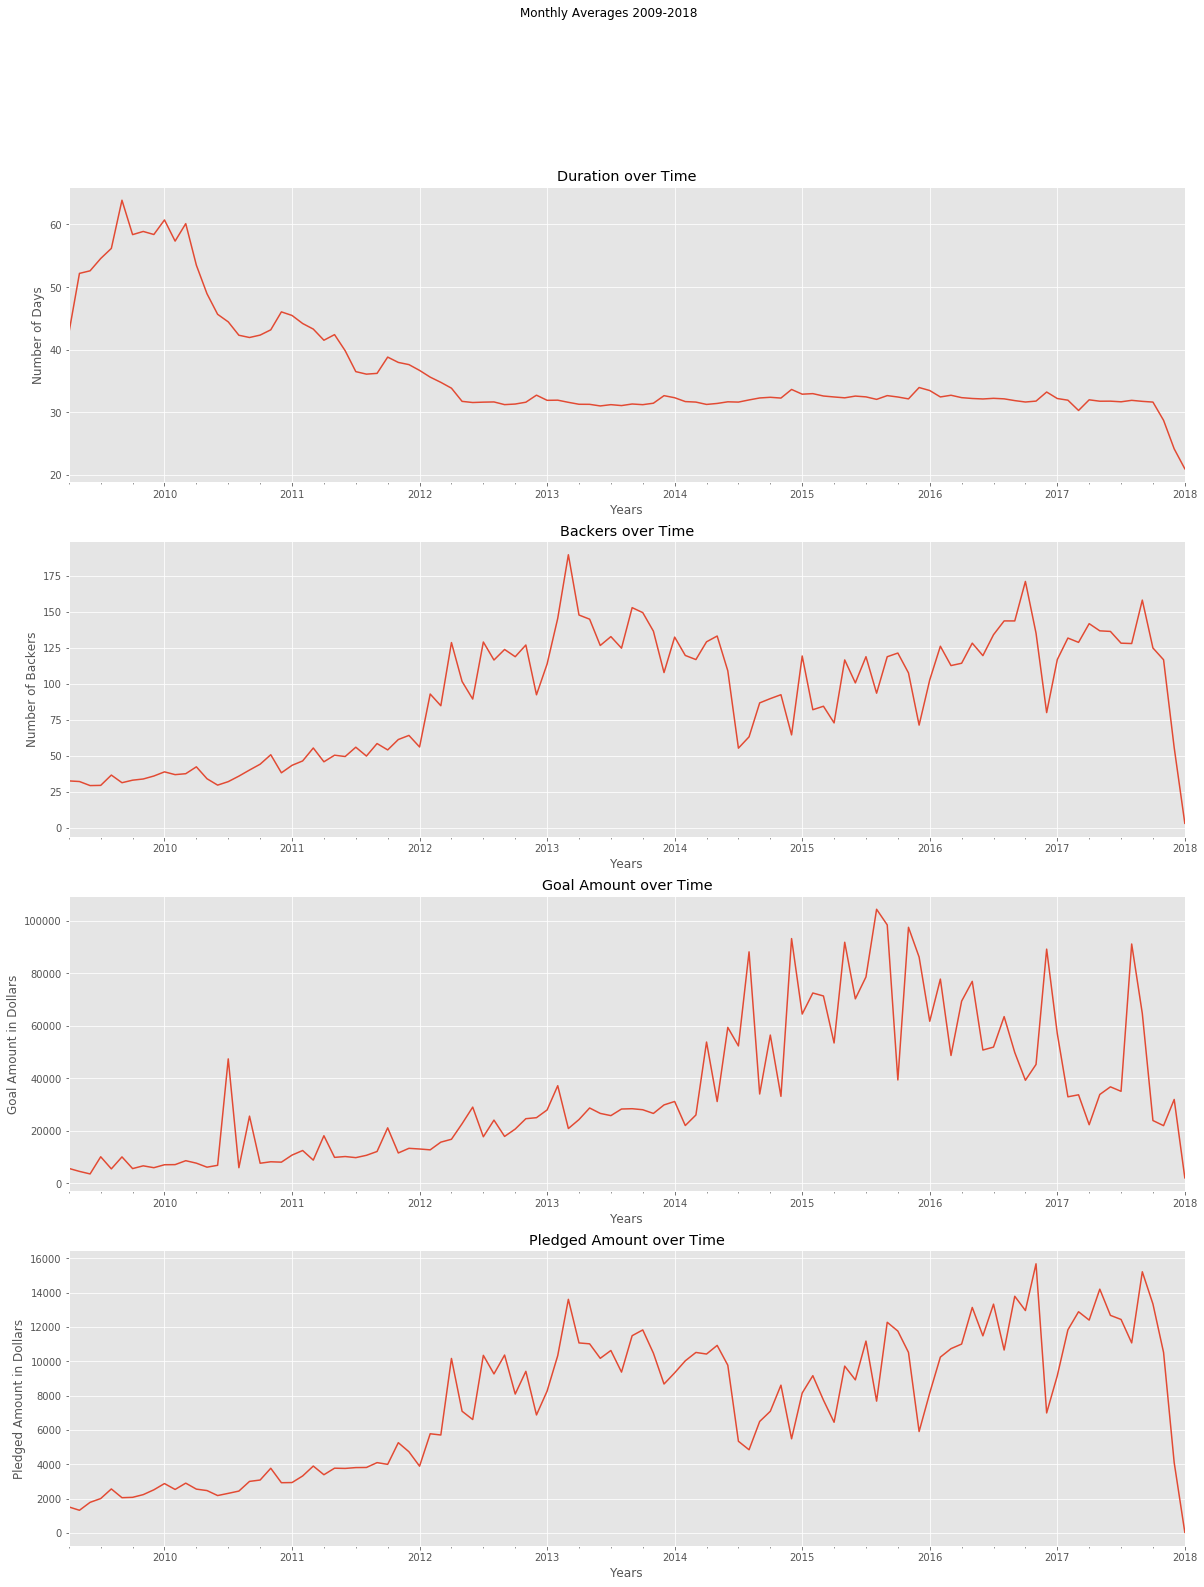

In [8]:
#create df with launch date as index for time series
time = df_clean.set_index('launched')
time_sorted = time.sort_index()
time_sorted['log_goal'] = np.log(time_sorted['usd_goal_real'])
time_sorted['log_pledged'] = np.log(time_sorted['usd_pledged_real'])
time_sorted['year'] = time_sorted.index.year

#time series plots
fig, ax =  plt.subplots(4, figsize=(20,25))
fig.suptitle('Monthly Averages 2009-2018')
ax[0] = time_sorted['duration'].resample('M').mean().plot(ax=ax[0], title='Duration over Time')
ax[0].set_ylabel('Number of Days')
ax[0].set_xlabel('Years')
ax[1] = time_sorted['backers'].resample('M').mean().plot(ax=ax[1], title='Backers over Time')
ax[1].set_ylabel('Number of Backers')
ax[1].set_xlabel('Years')
ax[2] = time_sorted['usd_goal_real'].resample('M').mean().plot(ax=ax[2], title='Goal Amount over Time')
ax[2].set_ylabel('Goal Amount in Dollars')
ax[2].set_xlabel('Years')
ax[3] = time_sorted['usd_pledged_real'].resample('M').mean().plot(ax=ax[3], title='Pledged Amount over Time')
ax[3].set_ylabel('Pledged Amount in Dollars')
ax[3].set_xlabel('Years')
plt.show()


# Statistical Tests

In this section I run t-tests and permutation tests on numerical data and chi-squared tests on categorical data to determine whether differences in distribution between successful and failed projects are statistically significant - that is, whether or not they could have been randomly achieved. 

## Numerical Data

### Boxplots

These boxplots visually show the differences in means and quartiles for successful and failed projects across key areas.

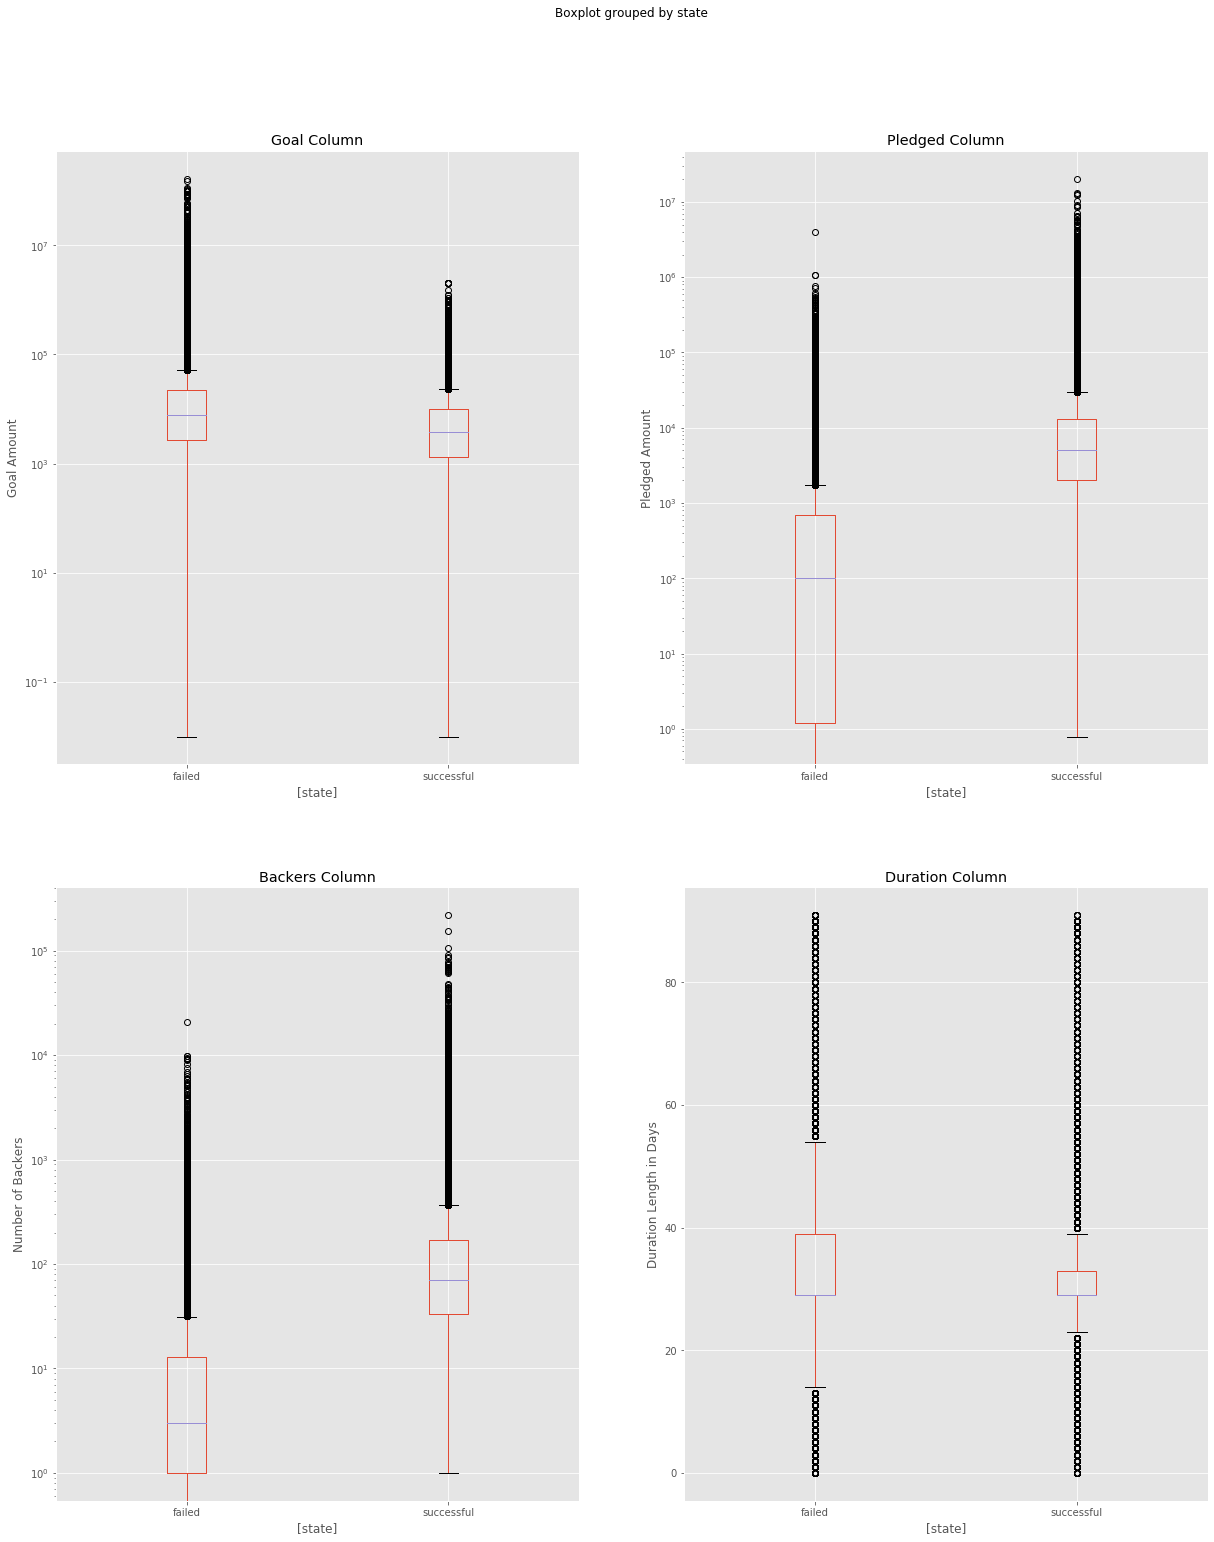

In [9]:

fig, ax =  plt.subplots(2,2, figsize=(20,25))
fig.suptitle('Boxplots of Numeric Columns')
df_clean.boxplot(ax=ax[0][0], column=['usd_goal_real'], by = ['state']).set_yscale('log')
ax[0][0].set_title('Goal Column')
ax[0][0].set_ylabel('Goal Amount')
df_clean.boxplot(ax=ax[0][1], column=['usd_pledged_real'], by = ['state']).set_yscale('log')
ax[0][1].set_title('Pledged Column')
ax[0][1].set_ylabel('Pledged Amount')
df_clean.boxplot(ax=ax[1][0], column=['backers'], by = ['state']).set_yscale('log')
ax[1][0].set_title('Backers Column')
ax[1][0].set_ylabel('Number of Backers')
df_clean.boxplot(ax=ax[1][1], column=['duration'], by = ['state'])
ax[1][1].set_title('Duration Column')
ax[1][1].set_ylabel('Duration Length in Days')
plt.show()



### T-Tests

The t-test tests for significant differences between sample groups. It takes the null hypothesis that the two independent samples have identical expected values. In this case, our independent samples are successful projects and failed projects, for each key area. The test returns the t-statistic and the p-value. The t-statistic measures difference between the two groups, so the larger the statistic, the more different. The p-value measures the probability that the samples are random, so the lower the p-value, the less likely that is. Since the p-values in all cases are zero or close to zero, we can say that these samples are not random, and we can reject the null hypothesis.

In [10]:
#ttest
#two-sided t-test for two independent samples, not assuming equal variance
''' 
This is a two-sided test for the null hypothesis that 2 independent samples 
have identical average (expected) values.
''' 
#goal column
success_goal = df_clean['usd_goal_real'].loc[df_clean.rate == 1]
failed_goal = df_clean['usd_goal_real'].loc[df_clean.rate == 0]
goal_result = stats.ttest_ind(success_goal, failed_goal, equal_var=False)

#pledged column
success_pledged = df_clean['usd_pledged_real'].loc[df_clean.rate == 1]
failed_pledged = df_clean['usd_pledged_real'].loc[df_clean.rate == 0]
pledged_result = stats.ttest_ind(success_pledged, failed_pledged, equal_var=False)

#backers column
success_backers = df_clean['backers'].loc[df_clean.rate == 1]
failed_backers = df_clean['backers'].loc[df_clean.rate == 0]
backers_result = stats.ttest_ind(success_backers, failed_backers, equal_var=False)

#duration column
success_duration = df_clean['duration'].loc[df_clean.rate == 1]
failed_duration = df_clean['duration'].loc[df_clean.rate == 0]
duration_result = stats.ttest_ind(success_duration, failed_duration, equal_var=False)

print("T-test result goal column: {}".format(goal_result))
print("T-test result pledged column: {}".format(pledged_result))
print("T-test result backers column: {}".format(backers_result))
print("T-test result duration column: {}".format(duration_result))


T-test result goal column: Ttest_indResult(statistic=-19.174819993757023, pvalue=6.926368189193366e-82)
T-test result pledged column: Ttest_indResult(statistic=51.081720315145375, pvalue=0.0)
T-test result backers column: Ttest_indResult(statistic=59.57593278469523, pvalue=0.0)
T-test result duration column: Ttest_indResult(statistic=-75.00443567428742, pvalue=0.0)


### Permutation Tests

The permutation test takes the observed difference between the two samples and compares it with the differences of the samples permuted to test whether the observed difference could have randomly occurred. Below I permuted the data 1000 times for each key area and compared the difference of means of each permutation with the difference of observed mean. In all cases, the probability of finding the difference of observed mean within the distribution of difference of means from the permutation replicates was zero.

In [11]:
#set functions for permutation testing
#we only need to set these once


#function for difference of means
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays, function from Datacamp 
    statistical thinking with python 2.."""

    # The difference of means of data_1, data_2: diff
    empirical_diff_means = np.mean(data_1) - np.mean(data_2)

    return empirical_diff_means


#function for recombining and sampling randomly from the data
def permutation_sample(data_1, data_2):
    """Generate a permutation sample from two data sets, function from Datacamp 
    statistical thinking with python 2."""

    # Concatenate the data sets: data
    data = np.concatenate((data_1, data_2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data_1)]
    perm_sample_2 = permuted_data[len(data_1):]

    return perm_sample_1, perm_sample_2


#function for generating new arrays
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates, function from Datacamp 
    statistical thinking with python 2."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates



# permutation test and p-value calculation using the above three functions

#random seed so it can be replicated
np.random.seed(47)
# Draw 1000 permutation replicates: perm_replicates
goal_perm_replicates = draw_perm_reps(success_goal, failed_goal, diff_of_means, size=1000)
#calculating the empirical difference of means
goal_empirical_diff_means = diff_of_means(success_goal, failed_goal)
# Compute p-value: p
goal_p = np.sum(goal_perm_replicates <= goal_empirical_diff_means) / len(goal_perm_replicates)

#random seed so it can be replicated
np.random.seed(47)
# Draw 1000 permutation replicates: perm_replicates
pledged_perm_replicates = draw_perm_reps(success_pledged, failed_pledged, diff_of_means, size=1000)
#calculating the empirical difference of means
pledged_empirical_diff_means = diff_of_means(success_pledged, failed_pledged)
# Compute p-value: p
pledged_p = np.sum(pledged_perm_replicates >= pledged_empirical_diff_means) / len(pledged_perm_replicates)

#random seed so it can be replicated
np.random.seed(47)
# Draw 1000 permutation replicates: perm_replicates
backers_perm_replicates = draw_perm_reps(success_backers, failed_backers, diff_of_means, size=1000)
#calculating the empirical difference of means
backers_empirical_diff_means = diff_of_means(success_backers, failed_backers)
# Compute p-value: p
backers_p = np.sum(backers_perm_replicates >= backers_empirical_diff_means) / len(backers_perm_replicates)

#random seed so it can be replicated
np.random.seed(47)
# Draw 1000 permutation replicates: perm_replicates
duration_perm_replicates = draw_perm_reps(success_duration, failed_duration, diff_of_means, size=1000)
#calculating the empirical difference of means
duration_empirical_diff_means = diff_of_means(success_duration, failed_duration)
# Compute p-value: p
duration_p = np.sum(duration_perm_replicates <= duration_empirical_diff_means) / len(duration_perm_replicates)

# Print the result
print('p-value for goal column =', goal_p)
print('p-value for pledged column =', pledged_p)
print('p-value for backers column =', backers_p)
print('p-value for duration column =', duration_p)


p-value for goal column = 0.0
p-value for pledged column = 0.0
p-value for backers column = 0.0
p-value for duration column = 0.0


Below we can visualize the results of the permutation test. Each histogram shows the distribution of differences of means from the permutation replicates. The solid blue line show the difference of means of the permutation replicate means, and the dotted blue line shows the difference of the observed mean. As we can see, the observed mean difference is too extreme in each case to have been randomly occurring.

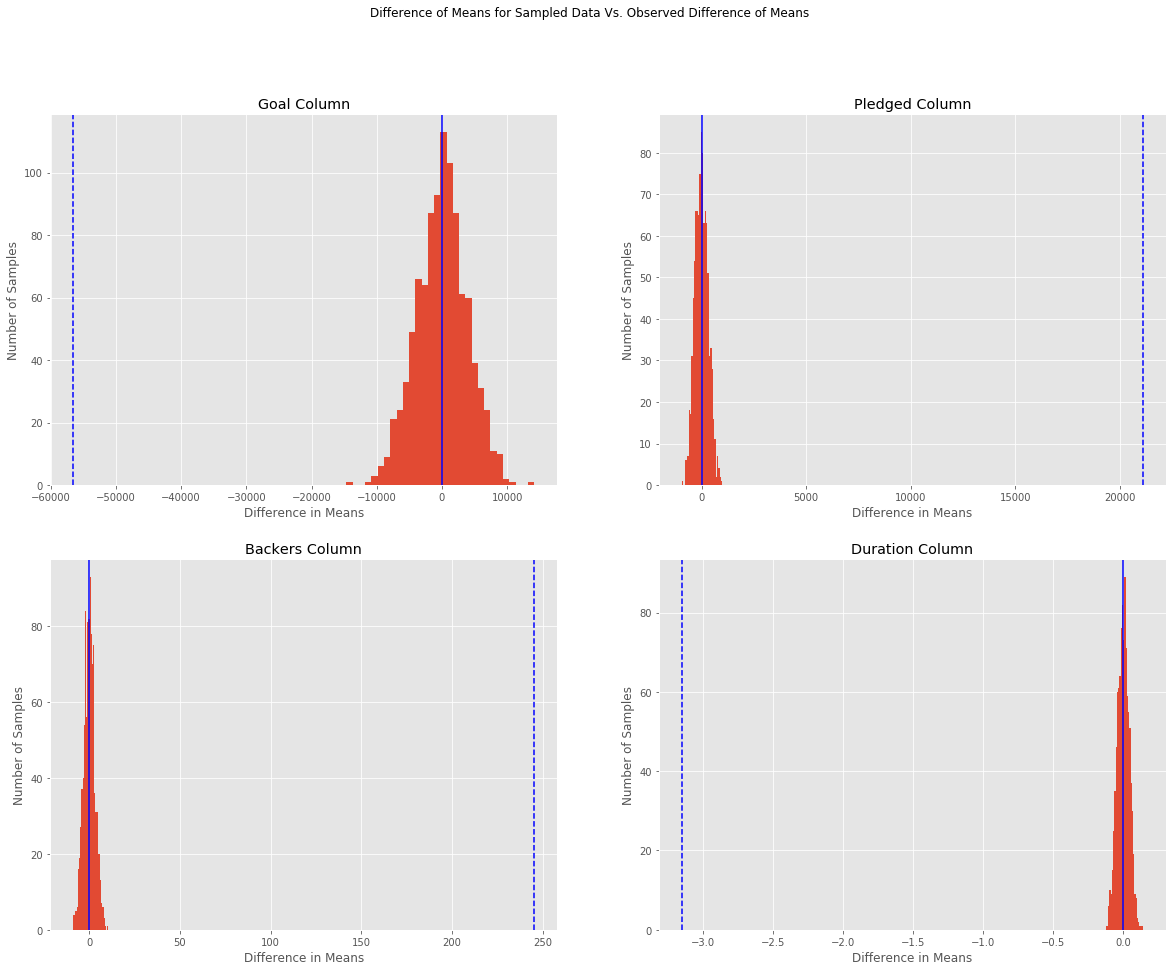

In [12]:
#plot of permutation test: difference of means

fig, ax =  plt.subplots(2,2, figsize=(20,15))
fig.suptitle('Difference of Means for Sampled Data Vs. Observed Difference of Means')
#goal column
ax[0][0].hist(goal_perm_replicates, bins=30)
ax[0][0].set_title('Goal Column')
ax[0][0].set_xlabel('Difference in Means')
ax[0][0].set_ylabel('Number of Samples')
ax[0][0].axvline(goal_perm_replicates.mean(), color='b')
ax[0][0].axvline(goal_empirical_diff_means, color='b', linestyle='--')
#pledged column
ax[0][1].hist(pledged_perm_replicates, bins=30)
ax[0][1].set_title('Pledged Column')
ax[0][1].set_xlabel('Difference in Means')
ax[0][1].set_ylabel('Number of Samples')
ax[0][1].axvline(pledged_perm_replicates.mean(), color='b')
ax[0][1].axvline(pledged_empirical_diff_means, color='b', linestyle='--')
#backers column
ax[1][0].hist(backers_perm_replicates, bins=30)
ax[1][0].set_title('Backers Column')
ax[1][0].set_xlabel('Difference in Means')
ax[1][0].set_ylabel('Number of Samples')
ax[1][0].axvline(backers_perm_replicates.mean(), color='b')
ax[1][0].axvline(backers_empirical_diff_means, color='b', linestyle='--')
#duration column
ax[1][1].hist(duration_perm_replicates, bins=30)
ax[1][1].set_title('Duration Column')
ax[1][1].set_xlabel('Difference in Means')
ax[1][1].set_ylabel('Number of Samples')
ax[1][1].axvline(duration_perm_replicates.mean(), color='b')
ax[1][1].axvline(duration_empirical_diff_means, color='b', linestyle='--')
plt.show()


## Categorical Data

To carry out statistical testing on the categorical data, I first converted each key column into a contingency table, then performed a Chi-squared test. The contingency table tabulates the frequency of occurences of each distinct value in a column, for both successful and unsuccessful projects. The Chi-squared test compares the observed values in the table with expected, or randomly achieved values. Like the other tests performed, this also assumes a null hypothesis that the observed data will be identical to the expected. For each column of categorical data in the dataset, we were able to reject the null hypothesis, again finding that it was unlikely these results were achieved by random chance.

### Chi-squared Tests

In [13]:
#create contingency tables for categorical data

#main category
contingency_maincat = pd.crosstab(index=df_clean["state"], columns=df_clean["main_category"])
contingency_maincat.index = ["failed","successful"]
#currency
contingency_country = pd.crosstab(index=df_clean["state"], columns=df_clean["currency"])
contingency_country.index = ["failed","successful"]
#country
contingency_currency = pd.crosstab(index=df_clean["state"], columns=df_clean["country"])
contingency_currency.index = ["failed","successful"]
#launch day of the month
contingency_launched = pd.crosstab(index=df_clean["state"], columns=df_clean["launched"].dt.day)
contingency_launched.index = ["failed","successful"]
#deadline day of the month
contingency_deadline = pd.crosstab(index=df_clean["state"], columns=df_clean["deadline"].dt.day)
contingency_deadline.index = ["failed","successful"]
#duration
contingency_duration = pd.crosstab(index=df_clean["state"], columns=df_clean["duration"])
contingency_duration.index = ["failed","successful"]

#chi-squared tests
#output is stat, p, dof, expected 
stat, maincat_p, dof, expected = stats.chi2_contingency(contingency_maincat)
stat, currency_p, dof, expected = stats.chi2_contingency(contingency_country)
stat, country_p, dof, expected = stats.chi2_contingency(contingency_currency)
stat, launched_p, dof, expected = stats.chi2_contingency(contingency_launched)
stat, deadline_p, dof, expected = stats.chi2_contingency(contingency_deadline)
stat, dur_p, dof, expected = stats.chi2_contingency(contingency_duration)

print('p-value for goal column =', maincat_p)
print('p-value for pledged column =', currency_p)
print('p-value for backers column =', country_p)
print('p-value for duration column =', launched_p)
print('p-value for goal column =', deadline_p)
print('p-value for pledged column =', dur_p)



p-value for goal column = 0.0
p-value for pledged column = 0.0
p-value for backers column = 0.0
p-value for duration column = 1.5949245085319634e-43
p-value for goal column = 1.2987566993263825e-57
p-value for pledged column = 0.0


# Machine Learning

In this section I further prepared the data for use in machine learning tasks, and then I tried a range of different classification models to find one that is most accurate in predicting the outcome of a project. The best performing model was K-Nearest Neighbors, below. 

## Preparation of Data for ML

First I dropped columns that were unnecessary from the data:

- Columns with all unique values (Index, ID, Name)
- Subcategory column, because it correlates with the main category
- USD Pledged column and State column, because data is repeated in the usd_pledged_real column and rate columns

Next I separated the date columns (launchdate and deadline) into year, month, and day columns, and then dropped the original date columns.

Next I took the remaining categorical columns (main category, country, currency) and converted them into numeric data with dummy variables and appended this with the rest of the numeric data.

Finally I separated the completely numeric dataframe into input and output variables for machine learning. For the input variable, I dropped the pledged amount columns, since knowing this amount would result in a 100% accuracy rate, and I dropped the rate column, since this is the output variable.

In [14]:
#prep data for ML

mldf = pd.read_csv('kickstarterClean.csv')

#drop columns: double-index, ID, name, sub-category, usd pledged (repeat), state (keep numeric rate)
mldf1 = mldf[['main_category', 'country', 'currency', 'goal', 'usd_goal_real', 'backers', 
              'pledged', 'usd_pledged_real', 'launched', 'deadline', 'duration', 'rate']]

#ensure date columns are in datetime format
mldf1['launched'] = pd.to_datetime(mldf1['launched'])
mldf1['deadline'] = pd.to_datetime(mldf1['deadline'])

#add new columns of separated launch dates
mldf1['launchyear'] = mldf1['launched'].dt.year
mldf1['launchmonth'] = mldf1['launched'].dt.month
mldf1['launchday'] = mldf1['launched'].dt.day

##add new columns of separated deadlines 
mldf1['deadlineyear'] = mldf1['deadline'].dt.year
mldf1['deadlinemonth'] = mldf1['deadline'].dt.month
mldf1['deadlineday'] = mldf1['deadline'].dt.day

#drop the original date columns
mldf2 = mldf1[['main_category', 'country', 'currency', 'goal', 'usd_goal_real', 
           'backers', 'pledged', 'usd_pledged_real', 'launchyear', 'launchmonth', 
           'launchday', 'deadlineyear', 'deadlinemonth', 'deadlineday', 'duration', 'rate']]

#create dummies for main_category, country, currency (categorical data)
dummy1 = pd.get_dummies(mldf2[['main_category', 'country', 'currency']], drop_first=True) 

#add dummies to the original dataframe
dummy_df = pd.concat([mldf2, dummy1], axis=1)

#drop the columns with the categorical data
dummy_final = dummy_df.drop(['main_category', 'country', 'currency'], axis=1)

#set X and y for ML
X = dummy_final.drop(['pledged', 'usd_pledged_real', 'rate'], axis=1)
y_classification = dummy_final['rate']
y_regression = dummy_final['usd_pledged_real']
X['extra_column'] = 1

X.head()

#data is all numeric!

,goal,usd_goal_real,backers,launchyear,launchmonth,launchday,deadlineyear,deadlinemonth,deadlineday,duration,...,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,extra_column
0,1000.0,1533.95,0,2015,8,11,2015,10,9,58,...,1,0,0,0,0,0,0,0,0,1
1,30000.0,30000.00,15,2017,9,2,2017,11,1,59,...,0,0,0,0,0,0,0,0,1,1
2,45000.0,45000.00,3,2013,1,12,2013,2,26,44,...,0,0,0,0,0,0,0,0,1,1
3,5000.0,5000.00,1,2012,3,17,2012,4,16,29,...,0,0,0,0,0,0,0,0,1,1
4,19500.0,19500.00,14,2015,7,4,2015,8,29,55,...,0,0,0,0,0,0,0,0,1,1


## Classification of Data with Decision Tree Model

Decision trees classify data by making decision about where to split data into groups, and then where to split subgroups into further divisions. In the default, it uses Gini purity to measure how mixed the samples in each subgroup are, and continues splitting until all leafs are pure. 

A decision tree model has a number of advantages that makes it a good candidate for a dataset like this one:

- works well with categorical values, and can discretize continuous values
- it is not susceptible to outliers
- it is a non-parametric algorithm, and therefore works for many functional forms
- it does not make assumptions about the distribution of data

There are also some drawbacks:

- it is easy to overfit
- the training can result in tree bias if certain features are more significant
- requires careful attention to parameter tuning


In [15]:
#decision tree with defaults
#first try is overfit!

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y_classification, test_size=0.2, random_state=42)

#instantiate the classifier
dt1 = DecisionTreeClassifier()

# Fit the model on the training data.
%time dt1.fit(X_train, y_train)

# accuracy score for training
train_accuracy = dt1.score(X_train, y_train)

# accuracy score for test set
test_accuracy = dt1.score(X_test, y_test)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))

CPU times: user 5.69 s, sys: 131 ms, total: 5.82 s
Wall time: 5.57 s
Training set score is 0.9999428853642066
Test set score is 0.8968177175724346


To solve the overfitting issue, I use cross-validation and hyperparameter tuning. The cross-validation and hyperparameter tuning further subdivides the data into training sets that are then used to optimize hyperparameters, in this case, max_depth, min_samples_leaf, and min_samples_split. Max_depth controls how far the tree splits, min_samples_leaf determines the minimum number of samples required in each leaf node, and min_samples_split controls the minumum number of samples required in a node for a split to occur. 


In [16]:

#KNN with tuned parameters and cross validation, performance metric is accuracy score

def performance_metric_accuracy(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = accuracy_score(y_true, y_predict)
    
    # Return the score
    return score

def fit_model_DT(X, y):
 
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 0)

    #  Create a logistic regression object
    regressor = DecisionTreeClassifier()

    #  Create a dictionary for the parameters 
    params = {'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [3, 5, 7]}
    
    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric_accuracy)

    #  Create the grid search object
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

%time result = fit_model_DT(X_train, y_train)
print(result)

CPU times: user 3min 35s, sys: 15.1 s, total: 3min 50s
Wall time: 3min 19s
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


Plug in the above tuned parameters into the instantiation of the model:

In [17]:
#decision tree with the parameters tuned 

#instantiate the classifier
dt2 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# Fit the model on the training data.
%time dt2.fit(X_train, y_train)

# accuracy score for training
train_accuracy = dt2.score(X_train, y_train)

# accuracy score for test set
test_accuracy = dt2.score(X_test, y_test)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))

CPU times: user 2.68 s, sys: 89.7 ms, total: 2.77 s
Wall time: 2.56 s
Training set score is 0.9288452428547911
Test set score is 0.9247164435843681


Next we can look at the data and see which columns are most important for the tree when making splitting decisions. We can see that backers is very important.

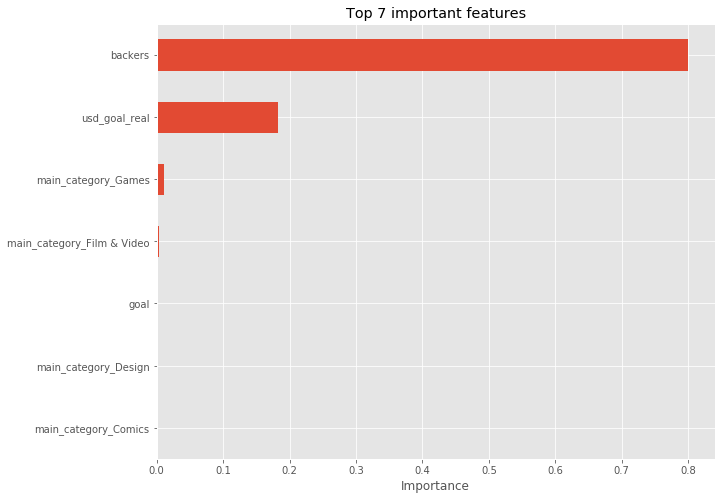

In [18]:
#graph feature importances
feat_importances = pd.Series(dt2.feature_importances_, index=X.columns)
feat_importances.nlargest(7).sort_values(ascending=True).plot(kind='barh', figsize=(10,8))
plt.title("Top 7 important features")
plt.xlabel("Importance")
plt.show()

In [19]:
#dataframe of feature importances
df_feat_importances = pd.DataFrame(dt2.feature_importances_, index = X.columns, 
                                             columns=['importance']).sort_values('importance', 
                                                                                 ascending=False)
df_feat_importances.head(10)

,importance
backers,0.799913
usd_goal_real,0.182676
main_category_Games,0.010681
main_category_Film & Video,0.002770
goal,0.002305
main_category_Design,0.000956
main_category_Comics,0.000348
main_category_Music,0.000235
duration,0.000070
main_category_Food,0.000047


Perhaps it is a good idea to try the model again without the backers column, since an individual starting a Kickstarter project is not going to know the number of backers right at the beginning of their project. When we try it again, it looks like the accuracy is greatly reduced.

In [20]:
#try decision tree one more time with no backers


#remove backers columm
X_nobackers = X.drop(['backers'], axis=1)

# Split the data into a training and test set.
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nobackers, 
                                                    y_classification, 
                                                    test_size=0.2, 
                                                    random_state=42)

#instantiate the classifier
dt3 = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# Fit the model on the training data.
%time dt3.fit(X_train_nb, y_train_nb)

# accuracy score for training
train_accuracy = dt3.score(X_train_nb, y_train_nb)

# accuracy score for test set
test_accuracy = dt3.score(X_test_nb, y_test_nb)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))

CPU times: user 3.97 s, sys: 123 ms, total: 4.1 s
Wall time: 3.74 s
Training set score is 0.6506062550605247
Test set score is 0.6428936193087137


We can see that without the backers column, the decision tree relies on the usd_goal_real column to split.

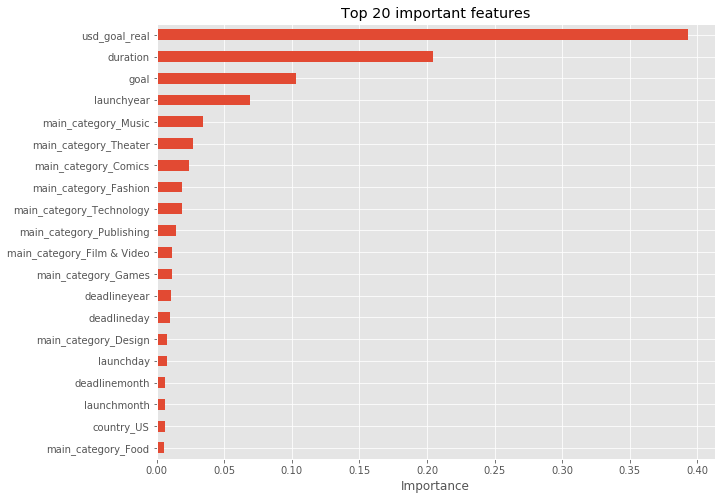

In [21]:
#plot feature importances when backers column is excluded.
feat_importances_nobackers = pd.Series(dt3.feature_importances_, index=X_nobackers.columns)
feat_importances_nobackers.nlargest(20).sort_values(ascending=True).plot(kind='barh', figsize=(10,8))
plt.title("Top 20 important features")
plt.xlabel("Importance")
plt.show()

In [22]:
df_feat_importances_nobackers = pd.DataFrame(dt3.feature_importances_, index = X_nobackers.columns, 
                                             columns=['importance']).sort_values('importance', 
                                                                                 ascending=False)
df_feat_importances_nobackers.head(10)

,importance
usd_goal_real,0.393132
duration,0.204186
goal,0.103153
launchyear,0.069102
main_category_Music,0.034564
main_category_Theater,0.026541
main_category_Comics,0.023716
main_category_Fashion,0.018659
main_category_Technology,0.018569
main_category_Publishing,0.013918


# Summary

When testing the decision tree model with default parameters, we did see that it overfit. And with the backers column removed, the performance was much less accurate. This may be due to some of the drawbacks of the decision tree model noted above. The backers column was clearly significant for splitting decisions, so it could be the case that the tree was biased and performed less well without it. This issue could also stem from the fact that both the backers and usd_goal_real columns were continuous. But even though it is continuous, the range of values in the backers column is much less than the range of values in usd_goal_real, which may make it easier to find repeated values and easier to discretize. 

In hindsight it might have been a good idea to leave the backers column out from the beginning in the machine learning section, as this is not a variable that would be known when first starting a project on Kickstarter. In other words, if we wanted to help individuals optimize their projects before going live, we should only look at variables that the project owners can control. However, in this case we looked at the number of backers without considering at all the amount contributed. Perhaps this can suggest that project owners who focus their efforts on getting as many backers as possible might increase their chances of success. In any case, if the number of backers is known in advance, without any data to suggest the amount pledged, it is possible to predict the success of a project at a fairly accurate rate.